# Clothes Similarity, inspired from TP1 CV finetuning

### Import

In [1]:
import numpy as np
import pandas as pd
import tensorflow
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense
import os 
from torch.utils.data import Dataset
import torchvision
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from datasets_emma import myDataset


C:\Users\emend\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Get the dataset


In [2]:
dir_path  = 'C:/Users/emend/3A_new/3A_new/Computer Vision/h-and-m-personalized-fashion-recommendations/images' ##############################
dataset = myDataset(dir_path, get_preprocessed_image= False)
dataset.create_smaller_dataset()

Created folder with 1000 images
Folder path: C:/Users/emend/3A_new/3A_new/Computer Vision/h-and-m-personalized-fashion-recommendations/images\smaller_dataset


'C:/Users/emend/3A_new/3A_new/Computer Vision/h-and-m-personalized-fashion-recommendations/images\\smaller_dataset'

### Available networks

We are going to use available pre-trained network Resnet-50.


In [3]:
# Charger le modèle ResNet50 pré-entraîné sans la couche de classification (top)
base_model = ResNet50(weights='imagenet', include_top=False)

# Extraire les caractéristiques de l'avant-dernière couche
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)


### X (directly from Resnet embeddings -> not trained) and y

In [4]:
# Chemin vers le répertoire contenant les images
data_dir  = 'C:/Users/emend/3A_new/3A_new/Computer Vision/h-and-m-personalized-fashion-recommendations/images/smaller_dataset' ##############################

# Charger les images et prétraiter pour l'inférence
X = []
for img_name in os.listdir(data_dir):
    img_path = os.path.join(data_dir, img_name)
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    X.append(np.squeeze(model.predict(x)))
X = np.array(X)

# Charger les labels de classes à partir du CSV
labels_df = pd.read_csv('C:/Users/emend/3A_new/3A_new/Computer Vision/h-and-m-personalized-fashion-recommendations/articles.csv')[['article_id', 'product_group_name']]
class_labels = labels_df['product_group_name'].values 
labels_df['article_id'] = labels_df['article_id'].astype(str)
keys_complete = os.listdir(data_dir)[:]
keys = [int(image_name[1:-4]) for image_name in keys_complete]
y = []
for idx in keys:
    idx = str(idx)
    if idx in labels_df['article_id'].values:
        y.append(labels_df[labels_df['article_id']==idx]['product_group_name'].values[0])
y = np.array(y)

1/1 [==============================] - 0s 123ms/step


### Split train/val/test (not used for now)

In [5]:
# Définir les proportions pour les ensembles d'entraînement, de validation et de test
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Calculer le nombre d'images pour chaque ensemble
num_images = len(X)
num_train = int(train_ratio * num_images)
num_val = int(val_ratio * num_images)
num_test = num_images - num_train - num_val

# Mélanger aléatoirement les indices des images
indices = np.random.permutation(num_images)

# Séparer les images en ensembles d'entraînement, de validation et de test
X_train = X[indices[:num_train]]
y_train = y[indices[:num_train]]
X_val = X[indices[num_train:num_train + num_val]]
y_val = y[indices[num_train:num_train + num_val]]
y_test = y[indices[num_train + num_val:]]


In [6]:
# Concaténer les ensembles d'entraînement et de validation pour l'analyse t-SNE
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])

# Créer un modèle Sequential pour ajouter des couches avant t-SNE
combined_model = Sequential([
    Flatten(),
    Dense(128, activation='relu')
])

# Appliquer le modèle combiné aux données d'entraînement et de validation
X_combined = combined_model(X_train_val)

### Plot TSNE (no training)

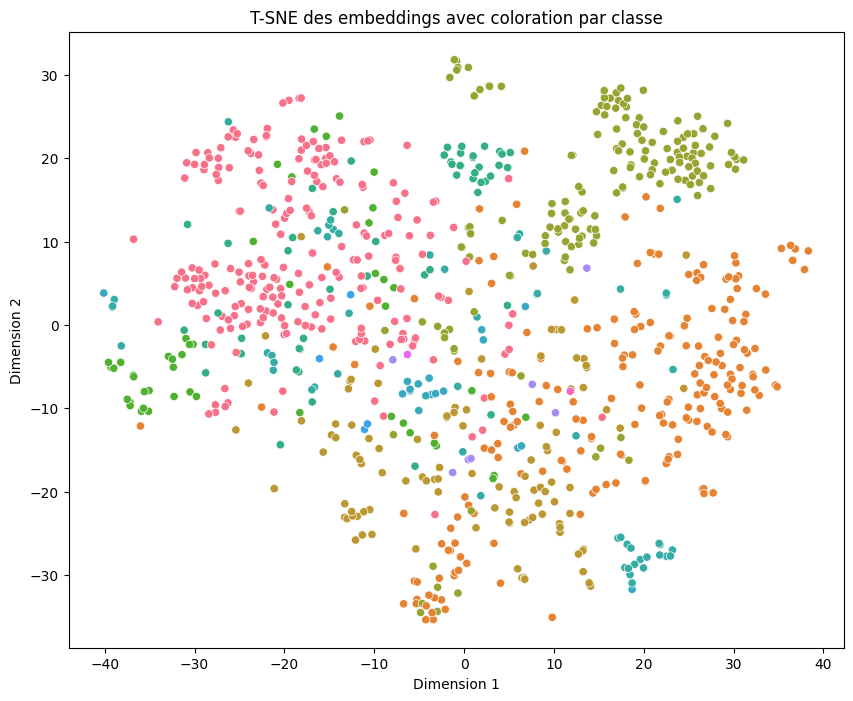

In [7]:
# Réduire la dimensionnalité avec t-SNE sur les données combinées
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_combined)

# Extraire les classes uniques
classes = np.unique(y_train_val)

# Créer une palette de couleurs en fonction du nombre de classes
palette = sns.color_palette("hls", len(classes))

# Créer un dictionnaire qui associe chaque classe à sa couleur
class_colors = {class_name: palette[i] for i, class_name in enumerate(classes)}

# Extraire les couleurs pour chaque point en fonction de sa classe
point_colors = [class_colors[class_label] for class_label in y_train_val]

# Tracer le graphique T-SNE avec les points colorés par classe
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=point_colors, legend=False)
plt.title('T-SNE des embeddings avec coloration par classe')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

### Code from TP1 CV

Batchs

In [11]:

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, ActivityRegularization, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.layers import AveragePooling2D, Input
from keras.utils import to_categorical
from keras.utils import normalize
from keras import backend as K

import os
import glob
import time

#import sklearn
#from sklearn.preprocessing import normalize

from tensorflow.keras.applications.vgg19 import VGG19
from keras.utils import load_img, img_to_array
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model


dir_path  = 'C:/Users/emend/3A_new/3A_new/Computer Vision/h-and-m-personalized-fashion-recommendations/images' ##############################
listDir = sorted(os.listdir(dir_path))
# print(len(listDir))



X_train = np.zeros(shape=(40*3,224,224,3), dtype=np.float32)# train batch

Y_train = np.zeros(shape=(40*3,3))
Y_train[0:40,0]=1
Y_train[40:80,1]=1
Y_train[80:120,2]=1


cpt = 0
# for d in listDir:#[listDir[1],  listDir[2] ,listDir[4]]:
#   #read subfolder
#   listFiles = sorted(os.listdir(dir_path+'/'+d))
#   print(d)
#   print(len(listFiles))
d = 'bigger_folder'
listfiles = os.listdir(dir_path+'/'+d)
for f in listFiles:
  img = load_img(dir_path+'/'+d+'/'+f, target_size=(224, 224))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  #print(x.shape)
  X_train[cpt,:,:,:] = x[0,:,:,:]
  cpt+=1
  print(cpt)

 #Use np.save(...) function if you want to save your train batch

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


### Build Similarly one batch for the test data X_test and its labels Y_test

In [ ]:
#TODO

### Build a new network based on a pre-trained network

In [5]:
network = VGG19(weights='imagenet')
print(network.summary())

network2 = Model(inputs=network.input, outputs=network.get_layer('block4_pool').output)#Use only the pre-trained convolutional layers
#######You may also use network with the option include_top = False
#print(network2.summary())
network2.trainable = False# this freezes the layers of this network, i.e. the layers will not be updated
print(network2.output_shape)


#Building a new network to plug after the first one.
input_shape = (14,14,512)

x = Input(shape=input_shape, name='input')
y0 = AveragePooling2D((14,14), padding='same')(x)# MaxPooling2D   AveragePooling2D ##### You may also use GlobalAveragePooling layers

y0 = Lambda(lambda x: K.l2_normalize(x, axis=-1))(y0)
y0 = Flatten()(y0)

y0 = Dense(3)(y0)##
y1 = Activation('softmax')(y0)

model1 = Model(inputs=x,outputs=y1)

#Combine the networks
modelf = Model(inputs=network2.input, outputs=model1(network2.output))
modelf.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
#print(modelf.summary())




574710816/574710816 [==============================] - 1500s 3us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                       

### Train the network

In [6]:
print(X_train.shape)
print(Y_train.shape)

modelf.fit(X_train, Y_train, batch_size=40, epochs=50, verbose=1)


(120, 224, 224, 3)
(120, 3)
Epoch 1/50


3/3 [==============================] - 14s 4s/step - loss: 1.1210 - accuracy: 0.0833
Epoch 2/50
3/3 [==============================] - 26s 9s/step - loss: 1.1185 - accuracy: 0.0917
Epoch 3/50
3/3 [==============================] - 31s 10s/step - loss: 1.1159 - accuracy: 0.0917
Epoch 4/50
3/3 [==============================] - 25s 8s/step - loss: 1.1135 - accuracy: 0.0917
Epoch 5/50
3/3 [==============================] - 23s 7s/step - loss: 1.1111 - accuracy: 0.1000
Epoch 6/50
3/3 [==============================] - 23s 8s/step - loss: 1.1086 - accuracy: 0.1083
Epoch 7/50
3/3 [==============================] - 25s 8s/step - loss: 1.1062 - accuracy: 0.1167
Epoch 8/50
3/3 [==============================] - 26s 9s/step - loss: 1.1038 - accuracy: 0.1167
Epoch 9/50
3/3 [==============================] - 26s 9s/step - loss: 1.1016 - accuracy: 0.1167
Epoch 10/50
3/3 [==============================] - 26s 9s/step - loss: 1.0992 - accuracy: 0.1250
Epoch 11

### Test the network on the test set

In [ ]:
#TODO

### Play with the architecture

> - Add 1 or 2 more fully connected layers (512 and 20 for exemple) with Relu and dropout ( https://keras.io/activations/ https://keras.io/layers/core/#dropout )

> - Switch the optimizer to adam ( https://keras.io/optimizers/ ). What do you observe ? why ?

> - Switch AveragePooling to MaxPooling

> - Replace l2 normalization with Bath norm.

> - Play with epochs and batch size

In [ ]:
#TODO

### Report the architectures tested and the performance obtained.

In [ ]:
#TODO

### Modify the network

> - Extract the first (then second) fully connected layer from the pre-trained vgg19 (There is no need for pooling and flatenning)

> - Compare your results to the convolutional layer


In [ ]:
#TODO

### Use another network

> - Choose another network, namely resnet, densenet, mobileNet, efficientNet...

> - Study its architecture

> - Similarly extract the final or penultimate convolutional layer, then add a couple of dense layers to perform classification. Compare performances with earlier networks.



In [ ]:
#TODO

### Play some more

> - re-compute your batch with larger images as input (twice as large for instance). Then use a fully convolutional architecture such as ResNet or VGG with the option include_top= False. Add a global average (or max) pooling layer (if necessary), followed by a dense classification layer.

In [ ]:
#TODO

##Optional

You may build or get your own dataset and perform classification on it.